# Example - M100 Fluke evaluation   
> **Model trained On the AM0.1-FLUKE dataset**  
Load the model and run inferences on the test dataset   
**[Run this file online in Colab](https://colab.research.google.com/github/johnnewto/cellsegment/blob/master/nbs/23_evaluation_M100_Fluke.ipynb)**

## Setup environment

In [35]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

def in_colab():
    "Check if the code is running in Google Colaboratory"
    try:
        from google import colab
        return True
    except: return False
IN_COLAB = in_colab()

In [2]:
#hide
if IN_COLAB:
    print('Cloning the cellsegment library')
    os.system('mkdir -p /root/.torch/models')
    os.system('mkdir -p /root/.fastai/data')
    os.system('ln -s /root/.torch/models /content')
    os.system('ln -s /root/.fastai/data /content')
    os.system('rm -rf /content/sample_data/')

### Imports

In [3]:
from cellsegment.core import *
from cellsegment.inference_utils import *
from cellsegment.set_directories import *
import pandas
from fastai import *
from fastai.vision import *

### Define directories

In [36]:
local_datapath = '../testdata/'
# local_datapath = '../../data/FEC/03-M100-Fluke-2019-11/'

dirs = Dirs('data') if IN_COLAB else Dirs(local_datapath)
dirs.model = dirs.model if IN_COLAB else '/home/john/github/data/FEC/03-M100-Fluke-2019-11/models'

print(dirs)

None
  basepath        :  ../testdata/         
  crop            :  ../testdata//Crop-200 
  cropLabel       :  ../testdata//Crop-200/Label 
  cropTest        :  ../testdata//Crop-200/Test 
  cropTrain       :  ../testdata//Crop-200/Train 
  cropValidTxtFile:  ../testdata//Crop-200/valid.txt 
  label           :  ../testdata//Fullsize/Label 
  model           :  /home/john/github/data/FEC/03-M100-Fluke-2019-11/models 
  originImages    :  ../testdata//Original 
  sizeCsvFile     :  ../testdata//file_size.csv 
  test            :  ../testdata//Fullsize/Test 
  train           :  ../testdata//Fullsize/Train 
  validTxtFile    :  ../testdata//Fullsize/valid.txt 



### Load the Training Images 
(if in colab)

In [37]:
%%bash
[[ ! -e /tools/google-cloud-sdk ]] &&  exit # if in colab

    export fileid=1SEW0Kf1CI4e4-up4TGsDqwDwVk_QZEUf
    export filename=Fluke-Train-2019-12-01.zip

    ## CURL ##
    curl -L -c cookies.txt 'https://docs.google.com/uc?export=download&id='$fileid \
         | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1/p' > confirm.txt
    curl -L -b cookies.txt -o $filename \
         'https://docs.google.com/uc?export=download&id='$fileid'&confirm='$(<confirm.txt)
    rm -f confirm.txt cookies.txt
    
    unzip -u -q $filename -d data

### Load exported Model

In [38]:
%%bash
[[ ! -e /tools/google-cloud-sdk ]] &&  exit # if in colab
switch=true
if $switch; then  
    export fileid=11cZWhg23QDag_3b7jcd02U8Pzq3W6U5Y
    export filename=export-fluke-2019-12-01.pkl

    ## CURL ##
    curl -L -c cookies.txt 'https://docs.google.com/uc?export=download&id='$fileid \
         | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1/p' > confirm.txt
    curl -L -b cookies.txt -o $filename \
         'https://docs.google.com/uc?export=download&id='$fileid'&confirm='$(<confirm.txt)
    rm -f confirm.txt cookies.txt
fi

## Run model inference on all of the test tiles

In [39]:
path = Path(dirs.basepath)/'Crop-200'
path_img = path/'Train'
path_lbl = path/'Label'
path_tst = path/'Test'

fnames =  get_image_files(path_tst)

print (f'Number of test tiles {len(fnames)}')

Number of test tiles 3


### Create Learner from exported model

In [8]:
# defaults.device = 'cpu'
defaults.device = 'cuda'

def acc_metric1(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

def acc_metric2(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)[target>0]==target[target>0]).float().mean()
    
fn_model = f'{dirs.model}/export-fluke-2019-12-01.pkl'
learn = load_learner('', fn_model)

learn.model.float()
# summary(learn.model, (3, 32, 32))
print("Learner loaded")


Learner loaded


## Inferences
> running an inference produces 3 tensors with the same xy dimensions

In [30]:
pc,pi,raw_pred = learn.predict(open_image(fnames[0]))
pc.data.max()

tensor(1)

In [ ]:
fn = fnames[1]
img = open_image(fnames[])
pc,pi,raw_pred = learn.predict(open_image(fnames[]))

fig, axes = plt.subplots(1, 4, figsize=(10, 3))

for i, ax in enumerate(axes.flat):
    arr = (raw_pred[i,:,:]).numpy()
    im = ax.imshow(arr, cmap='inferno', vmin=0, vmax=1)
    ax.set_axis_off()
    # plt.colorbar(im,ax=ax)

plt.tight_layout()

### Run inferences on the test tiles

In [32]:
path = Path(dirs.basepath)/'Crop-200'
path_img = path/'Train'
path_lbl = path/'Label'
path_tst = path/'Test'

fnames =  sorted(get_image_files(path_tst))

print (f'Number of test tiles to run {len(fnames)}')
preds= run_inferences(learn, fnames, number_files='all')
print (f'Number of predictions generated {len(preds)}')

Number of test tiles to run 83
Number of predictions generated 83


### Dataframe of inference probabilities

In [34]:
print(f'Populate dataframe in path {path_tst}')
df = pd.read_csv(path/"test_df.csv")

lst = add_cols_to_probs_df(df)
df.sort_values(by=['Name'])
df.to_csv(path/"test_df.csv")
df.tail(10)

print(f'Adding inference probs to the dataframe')
probs_to_df(preds, df)   
df.to_csv(dirs.crop+'/results_df.csv', index=False)
df.sort_values(by=['Name'], inplace=True)

print(f'Finding maximums')
df = pd.read_csv(path/"results_df.csv")
df["max_prob"] = df[["Background", "Fluke_Liver", "Fluke_Rumen"]].max(axis=1)
df.tail(10)
df.loc[df.Fluke_Liver == df.max_prob, "max_prob"] = 'Fluke-Liver'
df.loc[df.Fluke_Rumen == df.max_prob, "max_prob"] = 'Fluke-Rumen'
df.to_csv(dirs.crop+'/results_df.csv', index=False)

#print(df[['Name', 'Label', 'Pstr', 'max_prob']].tail(10))
sumary_df = df[['Name', 'Label', 'Pstr', 'max_prob']]
sumary_df

Populate dataframe in path ../../data/FEC/03-M100-Fluke-2019-11/Crop-200/Test
Adding inference probs to the dataframe
Finding maximums


Name        Label                  Pstr     max_prob
0    236568 - 14-0.jpg  Fluke-Liver  B:0.15 L:0.85 R:0.00  Fluke-Liver
1    236569 - 12-0.jpg  Fluke-Rumen  B:0.16 L:0.00 R:0.83  Fluke-Rumen
2    236569 - 12-1.jpg  Fluke-Rumen  B:0.13 L:0.00 R:0.87  Fluke-Rumen
3    236569 - 12-2.jpg  Fluke-Rumen  B:0.19 L:0.00 R:0.81  Fluke-Rumen
4    236569 - 12-3.jpg  Fluke-Rumen  B:0.20 L:0.00 R:0.80  Fluke-Rumen
5    236568 - 52-0.jpg  Fluke-Liver  B:0.16 L:0.84 R:0.00  Fluke-Liver
6    236568 - 57-0.jpg  Fluke-Liver  B:0.16 L:0.84 R:0.00  Fluke-Liver
7    236568 - 88-0.jpg  Fluke-Liver  B:0.15 L:0.85 R:0.00  Fluke-Liver
8    236568 - 88-1.jpg  Fluke-Liver  B:0.17 L:0.82 R:0.01  Fluke-Liver
9    235444 - 47-0.jpg  Fluke-Liver  B:0.16 L:0.84 R:0.00  Fluke-Liver
10   235444 - 47-1.jpg  Fluke-Liver  B:0.16 L:0.83 R:0.00  Fluke-Liver
11   235444 - 47-2.jpg  Fluke-Liver  B:0.16 L:0.84 R:0.00  Fluke-Liver
12    235445 - 1-0.jpg  Fluke-Liver  B:0.19 L:0.81 R:0.00  Fluke-Liver
13   236569 - 27-0.jpg  Fluke-Rumen  B:0.17 L:0.01 R:0.82  Fluke-Rumen
14   236566 - 38-0.jpg  Fluke-Liver  B:0.16 L:0.84 R:0.00  Fluke-Liver
15   236569 - 24-0.jpg  Fluke-Rumen  B:0.18 L:0.01 R:0.82  Fluke-Rumen
16   235444 - 12-0.jpg  Fluke-Liver  B:0.18 L:0.82 R:0.00  Fluke-Liver
17   235444 - 12-1.jpg  Fluke-Liver  B:0.38 L:0.61 R:0.01  Fluke-Liver
18   236571 - 25-0.jpg  Fluke-Rumen  B:0.22 L:0.00 R:0.78  Fluke-Rumen
19    235443 - 1-0.jpg  Fluke-Liver  B:0.16 L:0.84 R:0.00  Fluke-Liver
20    236571 - 6-0.jpg  Fluke-Rumen  B:0.18 L:0.00 R:0.82  Fluke-Rumen
21   236567 - 22-0.jpg  Fluke-Rumen  B:0.16 L:0.01 R:0.84  Fluke-Rumen
22    235443 - 3-0.jpg  Fluke-Liver  B:0.17 L:0.81 R:0.02  Fluke-Liver
23    235443 - 3-1.jpg  Fluke-Liver  B:0.14 L:0.85 R:0.00  Fluke-Liver
24   236568 - 75-0.jpg  Fluke-Liver  B:0.18 L:0.82 R:0.00  Fluke-Liver
25   235444 - 34-0.jpg  Fluke-Liver  B:0.18 L:0.81 R:0.01  Fluke-Liver
26   235444 - 15-0.jpg  Fluke-Liver  B:0.19 L:0.80 R:0.01  Fluke-Liver
27   235444 - 15-1.jpg  Fluke-Liver  B:0.15 L:0.85 R:0.00  Fluke-Liver
28   235444 - 15-2.jpg  Fluke-Liver  B:0.14 L:0.86 R:0.00  Fluke-Liver
29   236566 - 22-0.jpg  Fluke-Liver  B:0.19 L:0.81 R:0.00  Fluke-Liver
..                 ...          ...                   ...          ...
53   235444 - 35-1.jpg  Fluke-Liver  B:0.15 L:0.85 R:0.00  Fluke-Liver
54   235445 - 10-0.jpg  Fluke-Liver  B:0.19 L:0.81 R:0.00  Fluke-Liver
55   236569 - 10-0.jpg  Fluke-Rumen  B:0.16 L:0.00 R:0.84  Fluke-Rumen
56   235444 - 27-0.jpg  Fluke-Liver  B:0.20 L:0.80 R:0.00  Fluke-Liver
57   235444 - 27-1.jpg  Fluke-Liver  B:0.17 L:0.83 R:0.00  Fluke-Liver
58   235443 - 29-0.jpg  Fluke-Liver  B:0.19 L:0.80 R:0.00  Fluke-Liver
59   236571 - 24-0.jpg  Fluke-Rumen  B:0.16 L:0.01 R:0.83  Fluke-Rumen
60  236568 - 109-0.jpg  Fluke-Liver  B:0.16 L:0.81 R:0.03  Fluke-Liver
61  236568 - 113-0.jpg  Fluke-Liver  B:0.16 L:0.76 R:0.08  Fluke-Liver
62  236568 - 113-1.jpg  Fluke-Liver  B:0.16 L:0.69 R:0.15  Fluke-Liver
63  236568 - 110-0.jpg  Fluke-Liver  B:0.15 L:0.85 R:0.00  Fluke-Liver
64   235444 - 28-0.jpg  Fluke-Liver  B:0.25 L:0.75 R:0.00  Fluke-Liver
65   235443 - 20-0.jpg  Fluke-Liver  B:0.17 L:0.66 R:0.17  Fluke-Liver
66   235443 - 20-1.jpg  Fluke-Liver  B:0.17 L:0.66 R:0.16  Fluke-Liver
67   235443 - 15-0.jpg  Fluke-Liver  B:0.16 L:0.82 R:0.02  Fluke-Liver
68    236567 - 1-0.jpg  Fluke-Rumen  B:0.16 L:0.02 R:0.82  Fluke-Rumen
69    236567 - 1-1.jpg  Fluke-Rumen  B:0.14 L:0.00 R:0.86  Fluke-Rumen
70    236567 - 1-2.jpg  Fluke-Rumen  B:0.22 L:0.24 R:0.54  Fluke-Rumen
71   235445 - 23-0.jpg  Fluke-Liver  B:0.20 L:0.78 R:0.02  Fluke-Liver
72   235444 - 19-0.jpg  Fluke-Liver  B:0.18 L:0.82 R:0.00  Fluke-Liver
73    236571 - 3-0.jpg  Fluke-Rumen  B:0.20 L:0.00 R:0.79  Fluke-Rumen
74   236568 - 46-0.jpg  Fluke-Liver  B:0.15 L:0.85 R:0.00  Fluke-Liver
75   235444 - 11-0.jpg  Fluke-Liver  B:0.18 L:0.82 R:0.00  Fluke-Liver
76   235444 - 11-1.jpg  Fluke-Liver  B:0.17 L:0.83 R:0.00  Fluke-Liver
77    235444 - 2-0.jpg  Fluke-Liver  B:0.3

### Explanation of results

In [ ]:
pc,pi,raw_pred = learn.predict(open_image(fnames[0]))
pc.data.max()

In [ ]:
fn = fnames[1]
img = open_image(fnames[])
pc,pi,raw_pred = learn.predict(open_image(fnames[]))

fig, axes = plt.subplots(1, 4, figsize=(10, 3))

for i, ax in enumerate(axes.flat):
    arr = (raw_pred[i,:,:]).numpy()
    im = ax.imshow(arr, cmap='inferno', vmin=0, vmax=1)
    ax.set_axis_off()
    # plt.colorbar(im,ax=ax)

plt.tight_layout()

In [ ]:
### Plot of all the test tiles

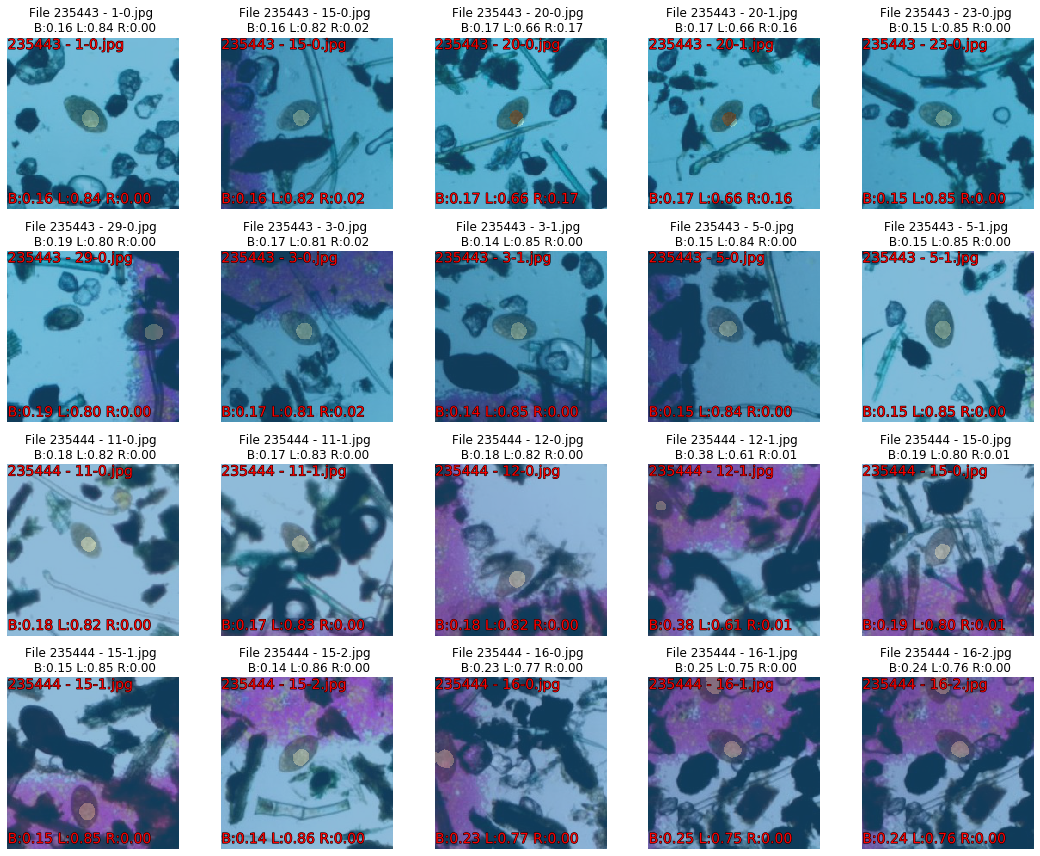

In [12]:
plot_inferences(preds, df, src_path=path_tst, start=0, rows=4)
# add the actual label   todo

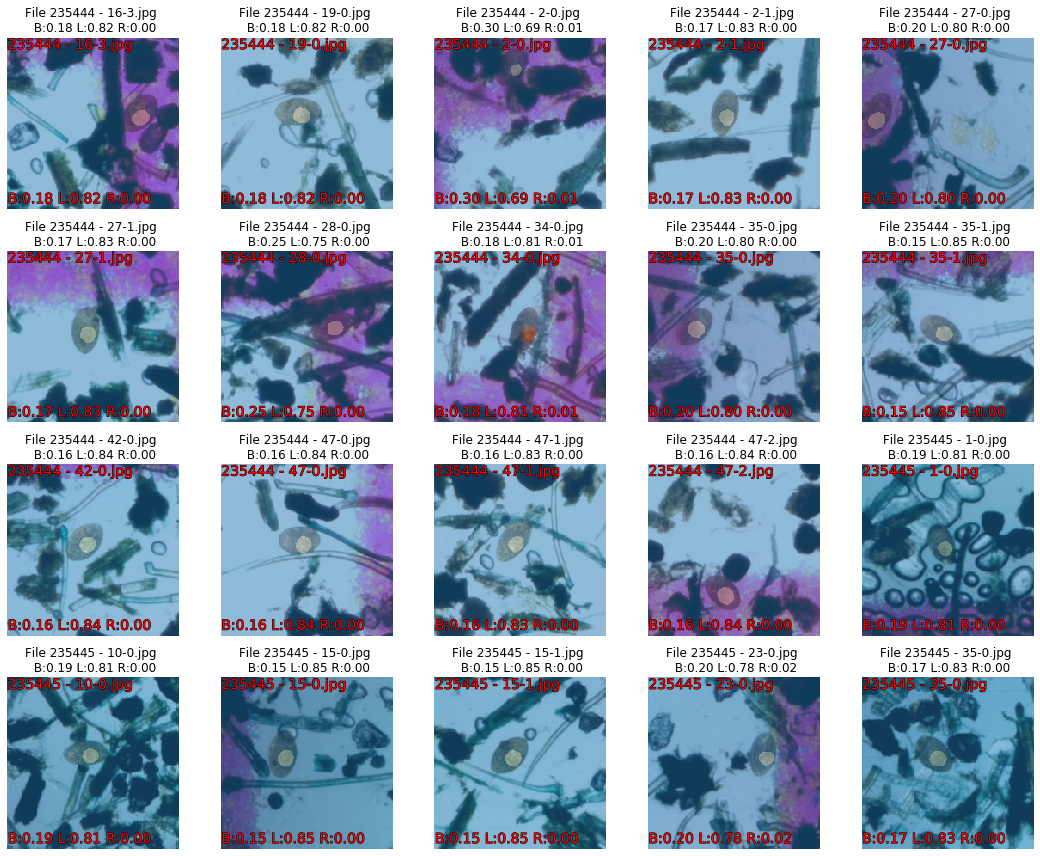

In [13]:
plot_inferences(preds, df, src_path=path_tst, start=20, rows=4)
# add the actual label   todo

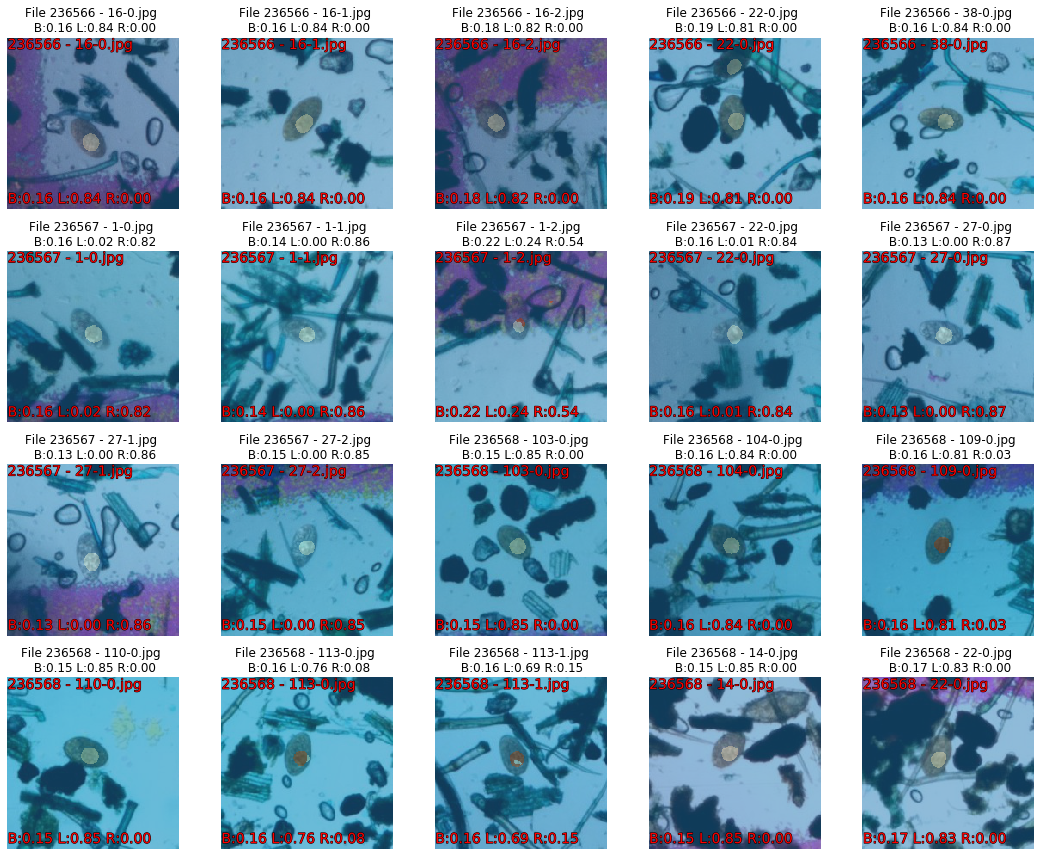

In [14]:
plot_inferences(preds, df, src_path=path_tst, start=40, rows=4)
# add the actual label   todo

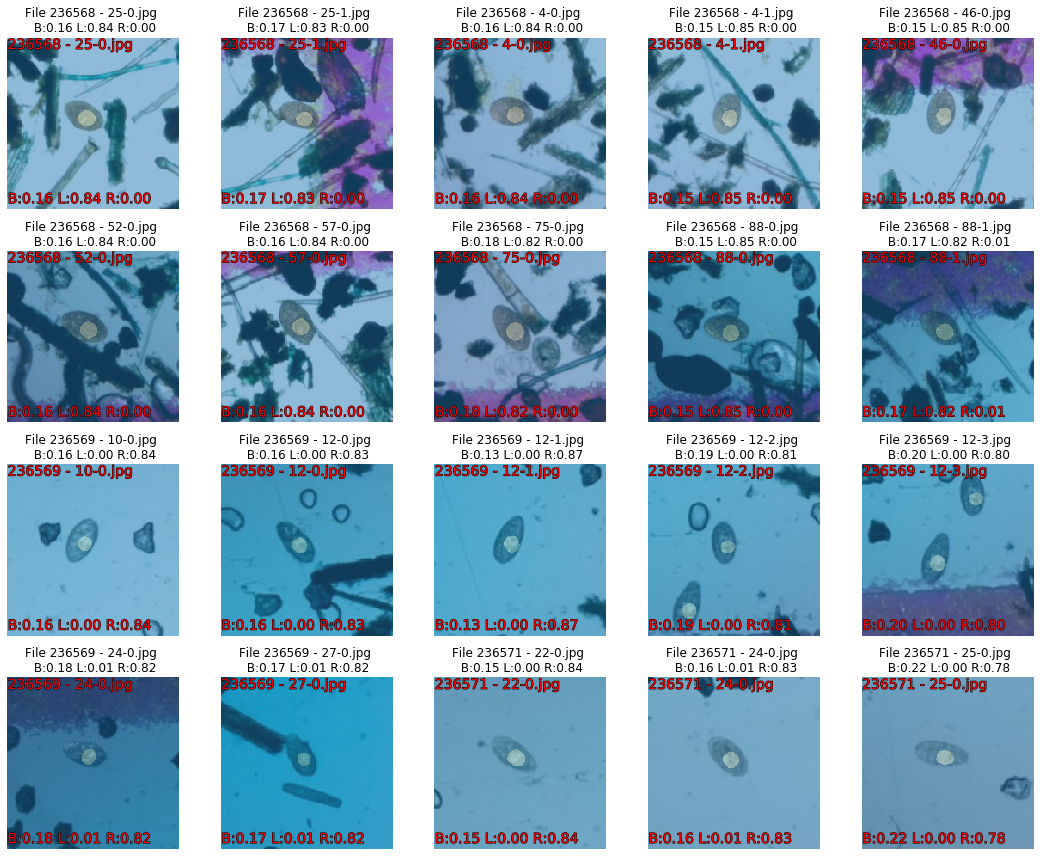

In [15]:
plot_inferences(preds, df, src_path=path_tst, start=60, rows=4)
# add the actual label   todo

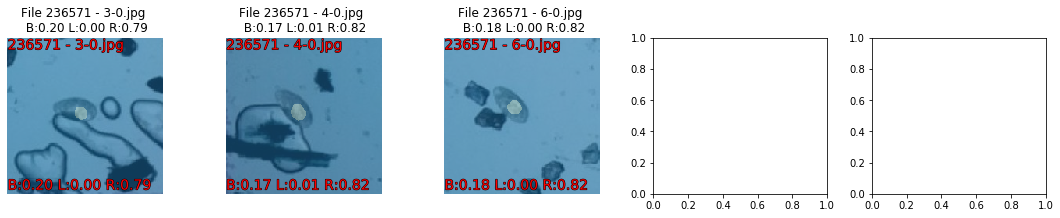

In [16]:
plot_inferences(preds, df, src_path=path_tst, start=80, rows=1)
# add the actual label   todo


In [ ]:
## 

0.16 0.84 0.00


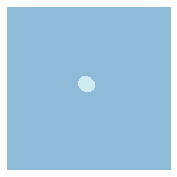

In [20]:
fnames =  sorted(get_image_files(path/'Test'))
fn = fnames[0]
img = open_image(fn)
pc,pi,raw_pred = learn.predict(img)

p = calc_probs(raw_pred)
print(f'{p[0]:3.2f} {p[1]:3.2f} {p[2]:3.2f}')
pc.show() 

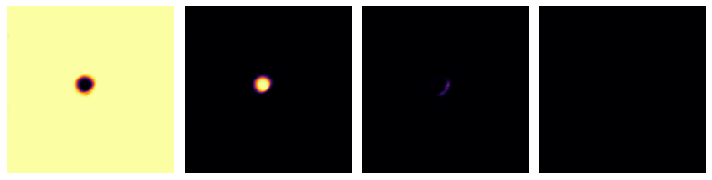

In [21]:
fn = fnames[1]
img = open_image(fn)
pc,pi,raw_pred = learn.predict(img)

fig, axes = plt.subplots(1, 4, figsize=(10, 3))

for i, ax in enumerate(axes.flat):
    arr = (raw_pred[i,:,:]).numpy()
    im = ax.imshow(arr, cmap='inferno', vmin=0, vmax=1)
    ax.set_axis_off()
    # plt.colorbar(im,ax=ax)

plt.tight_layout()

In [18]:
from skimage.measure import label, regionprops

def _get_props(tens, layer, min_conf):
    min_area = 100
    arr = o[layer,:,:].numpy()
    if layer == 0:
        label_arr = label(arr < 1-min_conf)
    else:
        label_arr = label(arr > min_conf)
        
    region_props = []
    for region in regionprops(label_arr, arr, cache=True):
        if region.area > min_area:
            cx = int(region.centroid[1])
            cy = int(region.centroid[0])
            region_props.append({ 
                "class_layer": layer,
                "centroid": region.centroid, 
                "mean_intensity": region.mean_intensity,
                "area": region.area,
                "coords": region.coords,
            })     
    return region_props

In [19]:
def _get_bool_mask(o):
    min_conf = 0.5
    arr = o[0,:,:].numpy()
    mask = np.zeros((arr.shape), dtype=bool)
    bgnd = _get_props(o, 0, min_conf)
    AAcoords = bgnd[0]["coords"]
    mask[AAcoords.T.tolist()] = True
    return mask

In [20]:
def _calc_probs(o):
    mask = _get_bool_mask(o)
    p = [None]*o.shape[0]
    for i in range(o.shape[0]):
        p[i] = o[i,:,:].numpy()[mask].mean()
        
    return p

## Calculate probability of marked up region

/home/john/.virtualenvs/cv/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys


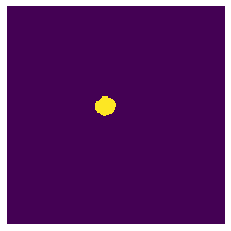

In [196]:
# # get boolean mask of a region
# mask = get_bool_mask(o)
# show_img(mask)

In [21]:
p = calc_probs(o)
print(f'{p[0]:3.2f} {p[1]:3.2f} {p[2]:3.2f}')

p
# print(f'{p:3.2f}')p
# print(f'{p0.mean():3.2f},{p1.mean():3.2f},{p2.mean():3.2f},{p3.mean():3.2f}')
# print(f'{(p0+p1+p2).mean():3.2f}')

0.10 0.02 0.88


/home/john/.virtualenvs/cv/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys


[0.096528605, 0.020488279, 0.88295305, 3.0051324e-05]

In [ ]:
min_conf = 0.2
bgnd = __get_props(o, 0, min_conf)
lyr1 = __get_props(o, 1, min_conf)
lyr1
lyr2 = __get_props(o, 2, min_conf)
lyr2
print(bgnd[0]["area"] )
print(lyr1[0]["area"], lyr1[0]["mean_intensity"], lyr1[0]["mean_intensity"] * lyr1[0]["area"] / bgnd[0]["area"])
print(lyr2[0]["area"], lyr2[0]["mean_intensity"], lyr2[0]["mean_intensity"] * lyr2[0]["area"] / bgnd[0]["area"])
# region.mean_intensity * region.area / 314
bgnd[0]["centroid"] 

print(o[0,90,90], o[1,90,90], o[2,90,90], o[3,90,90])

In [117]:
AAcoords = bgnd[0]["coords"]
AAcoords

array([[ 82,  89],
       [ 82,  90],
       [ 82,  91],
       [ 82,  92],
       ...,
       [100,  93],
       [100,  94],
       [101,  92],
       [101,  93]])

In [148]:
arr = o[0,:,:].numpy()
bin = label(arr < 0.5) > 0
bin.max()

True

In [149]:
AA0 = o[0,:,:].numpy()[bin]
AA0.mean()

0.096528605

In [150]:
AA1 = o[1,:,:].numpy()[bin]
AA1.mean()

0.020488279

In [151]:
AA2 = o[2,:,:].numpy()[bin]
AA2.mean()

0.88295305

In [152]:
(AA0+AA1+AA2).mean()

0.99996996

In [ ]:
def find_prediction_blobs(img, min_conf=0.1, min_area=100, plot=False):
    RESIZE = 2.0
    img = cv2.resize(img,None,fx=1.0/RESIZE, fy=1.0/RESIZE, interpolation = cv2.INTER_AREA)
    min_area = int(min_area/RESIZE)
    # region props seems to have region.max_intensity errors if no data not np.int 
    SCALE = 100
    min_conf *= SCALE
    img = (img * (SCALE/img.max())).astype(np.int)
    img[img[:,:,0]<min_conf,0] = 0
    img[img[:,:,1]<min_conf,1] = 0

    predictions = []


    label_image0 = label(img[:,:,0] > min_conf)
    label_image1 = label(img[:,:,1] > min_conf)

    for region in regionprops(label_image0, img[:,:,0], cache=True):
        if region.area > min_area:
            cx = int(region.centroid[1]*RESIZE)
            cy = int(region.centroid[0]*RESIZE)
            predictions.append({  
                "label": 'Strongyle', 
                "point": [cx,cy], 
                "probability": region.max_intensity.round(2),
                "area": region.area
            })  

    fill = (0,255,0)
    for region in regionprops(label_image1, img[:,:,1]):
        if region.area > min_area:
            cx = int(region.centroid[1]*RESIZE)
            cy = int(region.centroid[0]*RESIZE)
            predictions.append({
                "label": 'Nematodirus',
                "point": [cx,cy], 
                "probability": region.max_intensity.round(2),
                "area": region.area
            })
    if plot:
        #   show_img(imglab, figsize = (15,15))
        plt.figure(figsize=(15, 15))
        plt.subplot(121)
        plt.imshow(label_image0, cmap='nipy_spectral')
        #   plt.imshow(img[:,:,0] > min_conf, cmap='nipy_spectral')
        plt.axis('off')
        plt.subplot(122)
        plt.imshow(label_image1, cmap='nipy_spectral')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    return predictions, img